In [1]:

#import gradio as gr
from datasets import load_dataset
import numpy as np
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
from datasets import load_dataset
from PIL import Image, ImageDraw, ImageFont
import torch

tokenizer = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")
model = LayoutLMv3ForTokenClassification.from_pretrained(r"G:/Form understanding in Noisy scanned documents/trained_model")
device = torch.device("cuda")
model.cuda()

g:\IDEs and Modules\Anaconda\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [2]:

labels = ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']
id2label = {v: k for v, k in enumerate(labels)}
label2color = {
    "question": "blue",
    "answer": "green",
    "header": "orange",
    "other": "violet",
}



In [3]:
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


def iob_to_label(label):
    label = label[2:]
    if not label:
        return "other"
    return label

In [40]:
def process_image(image):
    image = image.convert("RGB")
    width, height = image.size
    

    # encode
    encoding = tokenizer(
        image, truncation=True, return_offsets_mapping=True, return_tensors="pt"
    )
    offset_mapping = encoding.pop("offset_mapping")
    
    encoding = encoding.to('cuda')

    # forward pass
    outputs = model(**encoding)
    
    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()
    

    # only keep non-subword predictions
    is_subword = np.array(offset_mapping.squeeze().tolist())[:, 0] != 0
    true_predictions = [
        id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]
    ]
    true_boxes = [
        unnormalize_box(box, width, height)
        for idx, box in enumerate(token_boxes)
        if not is_subword[idx]
    ]
    
    
    
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction).lower()
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text(
            (box[0] + 10, box[1] - 10),
            text=predicted_label,
            fill=label2color[predicted_label],
            font=font,
        )

    return image

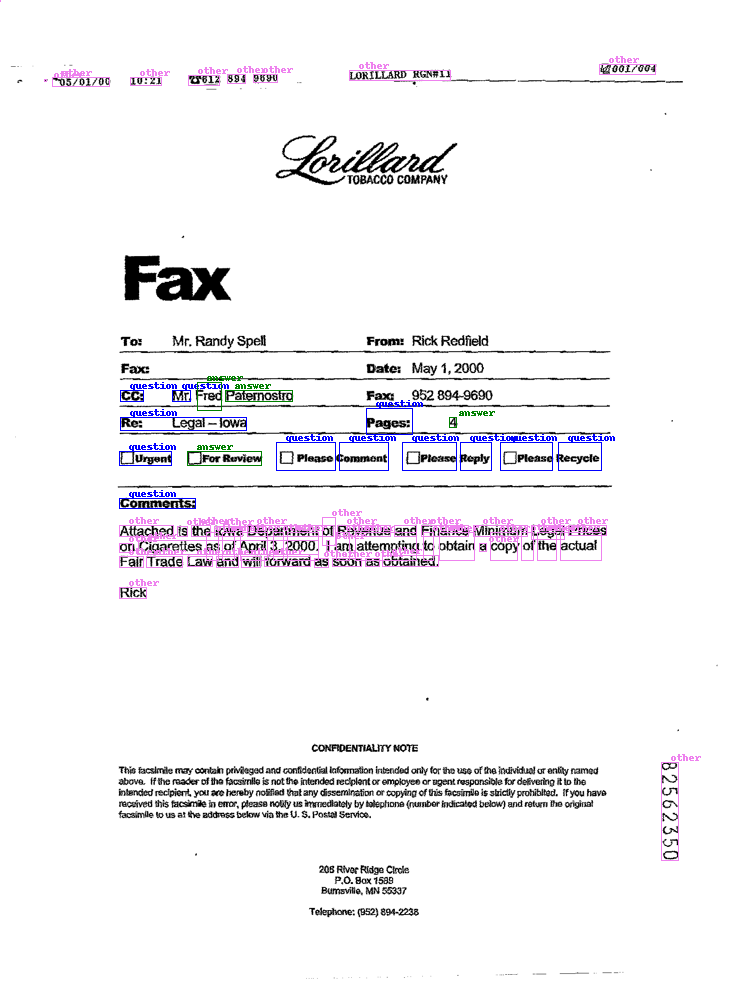

In [41]:

image = Image.open(r"G:/Form understanding in Noisy scanned documents/test_img_3.png")
process_image(image)